# Phylogenetic reconstruction using R

In this course we will take a look at the phylogenetics of the bacterial representative OTU sequences obtained in the data processing part.

* First we will import and filter the sequences.

* After making the corresponding alignments we will perform different approaches to phylogenetic inference.

* Finally, we will visualize and interpret the results.

Import the R packages we will need. 

In [9]:
library(ips)
library(ggtree)
library(phangorn)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks ggtree::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Sequence import  

Read the taxonomy file corresponding to the representative sequences using the `read_delim` function with the parameter `delim = "\t"` in order to fit the tab delimited format of the file.

In [10]:
taxonomy <- read_delim("BV5.trim.contigs.good.renamed.unique.pick.dgc.unique_list.0.03.abund.0.03.cons.taxonomy", delim = "\t")

Parsed with column specification:
cols(
  OTU = col_character(),
  Size = col_double(),
  Taxonomy = col_character()
)


Read the fasta file from the representative sequences using the the function `read.fas`. 

In [11]:
bv5t <- read.fas("BV5.trim.contigs.good.renamed.unique.pick.dgc.unique_list.0.03.abund.0.03.rep.fasta")

Inspect what the function `read.fas` does by adding `?` before the name of the function.

In [12]:
?read.fas

read                    package:ips                    R Documentation

_R_e_a_d_i_n_g _S_e_q_u_e_n_c_e _F_i_l_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     Read DNA and amino acid sequences from FASTA, PHILIP, and NEXUS
     formatted files.

_U_s_a_g_e:

     read.fas(x, text)
     
     read.nex(x)
     
     read.phy(x)
     
_A_r_g_u_m_e_n_t_s:

       x: A character string, giving the file name.

    text: A character string in FASTA format.

_V_a_l_u_e:

     An matrix (aligned sequences) or list (unaligned sequences) of
     class ‘DNAbin’ or ‘AAbin’.

_R_e_f_e_r_e_n_c_e_s:

     Maddison, D.R., D.L. Swofford, and W.P. Maddison. 1997. NEXUS: an
     extensible file format for systematic information. _Syst. Biol._
     *46*: 590-621.

_S_e_e _A_l_s_o:

     ‘mafft’ and ‘prank’ for sequence alignment, ‘gblocks’ and
     ‘aliscore’ for quality check and cleaning of sequence alignments,
     ‘cbind.DNAbin’ for concatenation of sequence alignments.

_E_x_a_m_p_l_e_s:

     ## bark beetle COX1 sequences
     data(ips.cox1)
     ## create temporary file names
     format <- c(".fas", ".phy", ".nex")
     fn <- sapply(format, tempfile, 
                  pattern = "ips", tmpdir = tempdir())
     ## write sequences files
     write.fas(ips.cox1, fn[".fas"])
     write.phy(ips.cox1, fn[".phy"])
     write.nex(ips.cox1, fn[".nex"])
     ## read sequence files
     fas <- read.fas(fn[".fas"])
     phy <- read.phy(fn[".phy"])
     nex <- read.nex(fn[".nex"])
     ## remove sequence files
     unlink(fn)

Inspect the created object with the DNA sequences.

In [13]:
bv5t

386 DNA sequences in binary format stored in a list.

Mean sequence length: 377.207 
   Shortest sequence: 334 
    Longest sequence: 431 

Labels:
6_B5.154
3590_B5.145
2019_B5.146
15303_B5.152
10_B5.154
4_B5.145
...

Base composition:
    a     c     g     t 
0.233 0.249 0.307 0.211 
(Total: 145.6 kb)

### Change fasta names to taxonomy
Replace the names of the imported fasta object with the imported taxonomy. Since they are in the same order this can be simply done by replacing the `names` attribute from the `bv5t` fasta object with the `Taxonomy` column from the `taxonomy` dataframe. To prevent problems further on we also rename the duplicated taxonomy descriptions using the `make.unique` function.

In [14]:
names(bv5t) <- make.unique(taxonomy$Taxonomy)

Take only the sequences annotated as bacterial, that is, those that start with "k__Bacteria(100)" from the `bv5t` fasta object and name it as `bv5`.

In [15]:
bv5 <- bv5t[startsWith(names(bv5t), "k__Bacteria(100)")]

Remove bacteria from name to be able to identify the phyla more easily. We do this by substracting the 21 first characters using the `substring` function with the parameter `first = 21`. 

In [16]:
names(bv5) <- substring(names(bv5), first = 21)

**Exercise**: How many OTU's are deleted?

In [17]:
## type here your answer

## Alignment

Align sequences using `mafft` aligner.

In [18]:
bv5_aligned = mafft(bv5, thread = 4)

**Exercise**: inspect the function `mafft`. What does the `thread` parameter do?

In [19]:
## type here your answer

Inspect the object containing the alignment

In [20]:
bv5_aligned

371 DNA sequences in binary format stored in a matrix.

All sequences of same length: 436 

Labels:
Proteobacteria(100);c__Alphaproteobacteria(100);o__Rhodospir...
Firmicutes(100);c__Bacilli(100);o__Lactobacillales(100);f__L...
Proteobacteria(100);c__Gammaproteobacteria(100);o__Enterobac...
Proteobacteria(100);c__Gammaproteobacteria(100);o__Pseudomon...
Proteobacteria(100);c__Alphaproteobacteria(100);o__Rhodospir...
Proteobacteria(100);c__Alphaproteobacteria(100);o__Rickettsi...
...

Base composition:
   a    c    g    t 
0.23 0.25 0.31 0.21 
(Total: 161.76 kb)

Write the alignment file to the working directory.

In [21]:
write.fas(bv5_aligned, "bv5.aln")

## Phylogenetic tree reconstruction

Read in the alignment file.

In [22]:
alignment <- read.phyDat("bv5.aln", format ="fasta")

Inspect the alignment object.

In [23]:
alignment

371 sequences with 436 character and 310 different site patterns.
The states are a c g t 

## Distance based methods

> Distance methods try to fit a tree to a matrix of pairwise genetic distances.

Advantage:
- Fast speed of calculation

Disadvantages:
- Often not accurate (particularly in highly divergent sequences)
- Loss of evolutionary information

- **Cluster analysis**
    - UPGMA (unweighted pair group method with arithmetic means). 
- **Minimum evolution**
    - Neighbour Joining

Construct a rooted tree using UPGMA and an unrooted one using NJ (Neighbour-joining).

In [24]:
dm <- dist.ml(alignment)
treeUPGMA  <- upgma(dm)
treeNJ  <- NJ(dm)

Visualize the tree with the tip names in small font using the `ggtree` package. The `geom_tip` adds the layer of leaf tips.

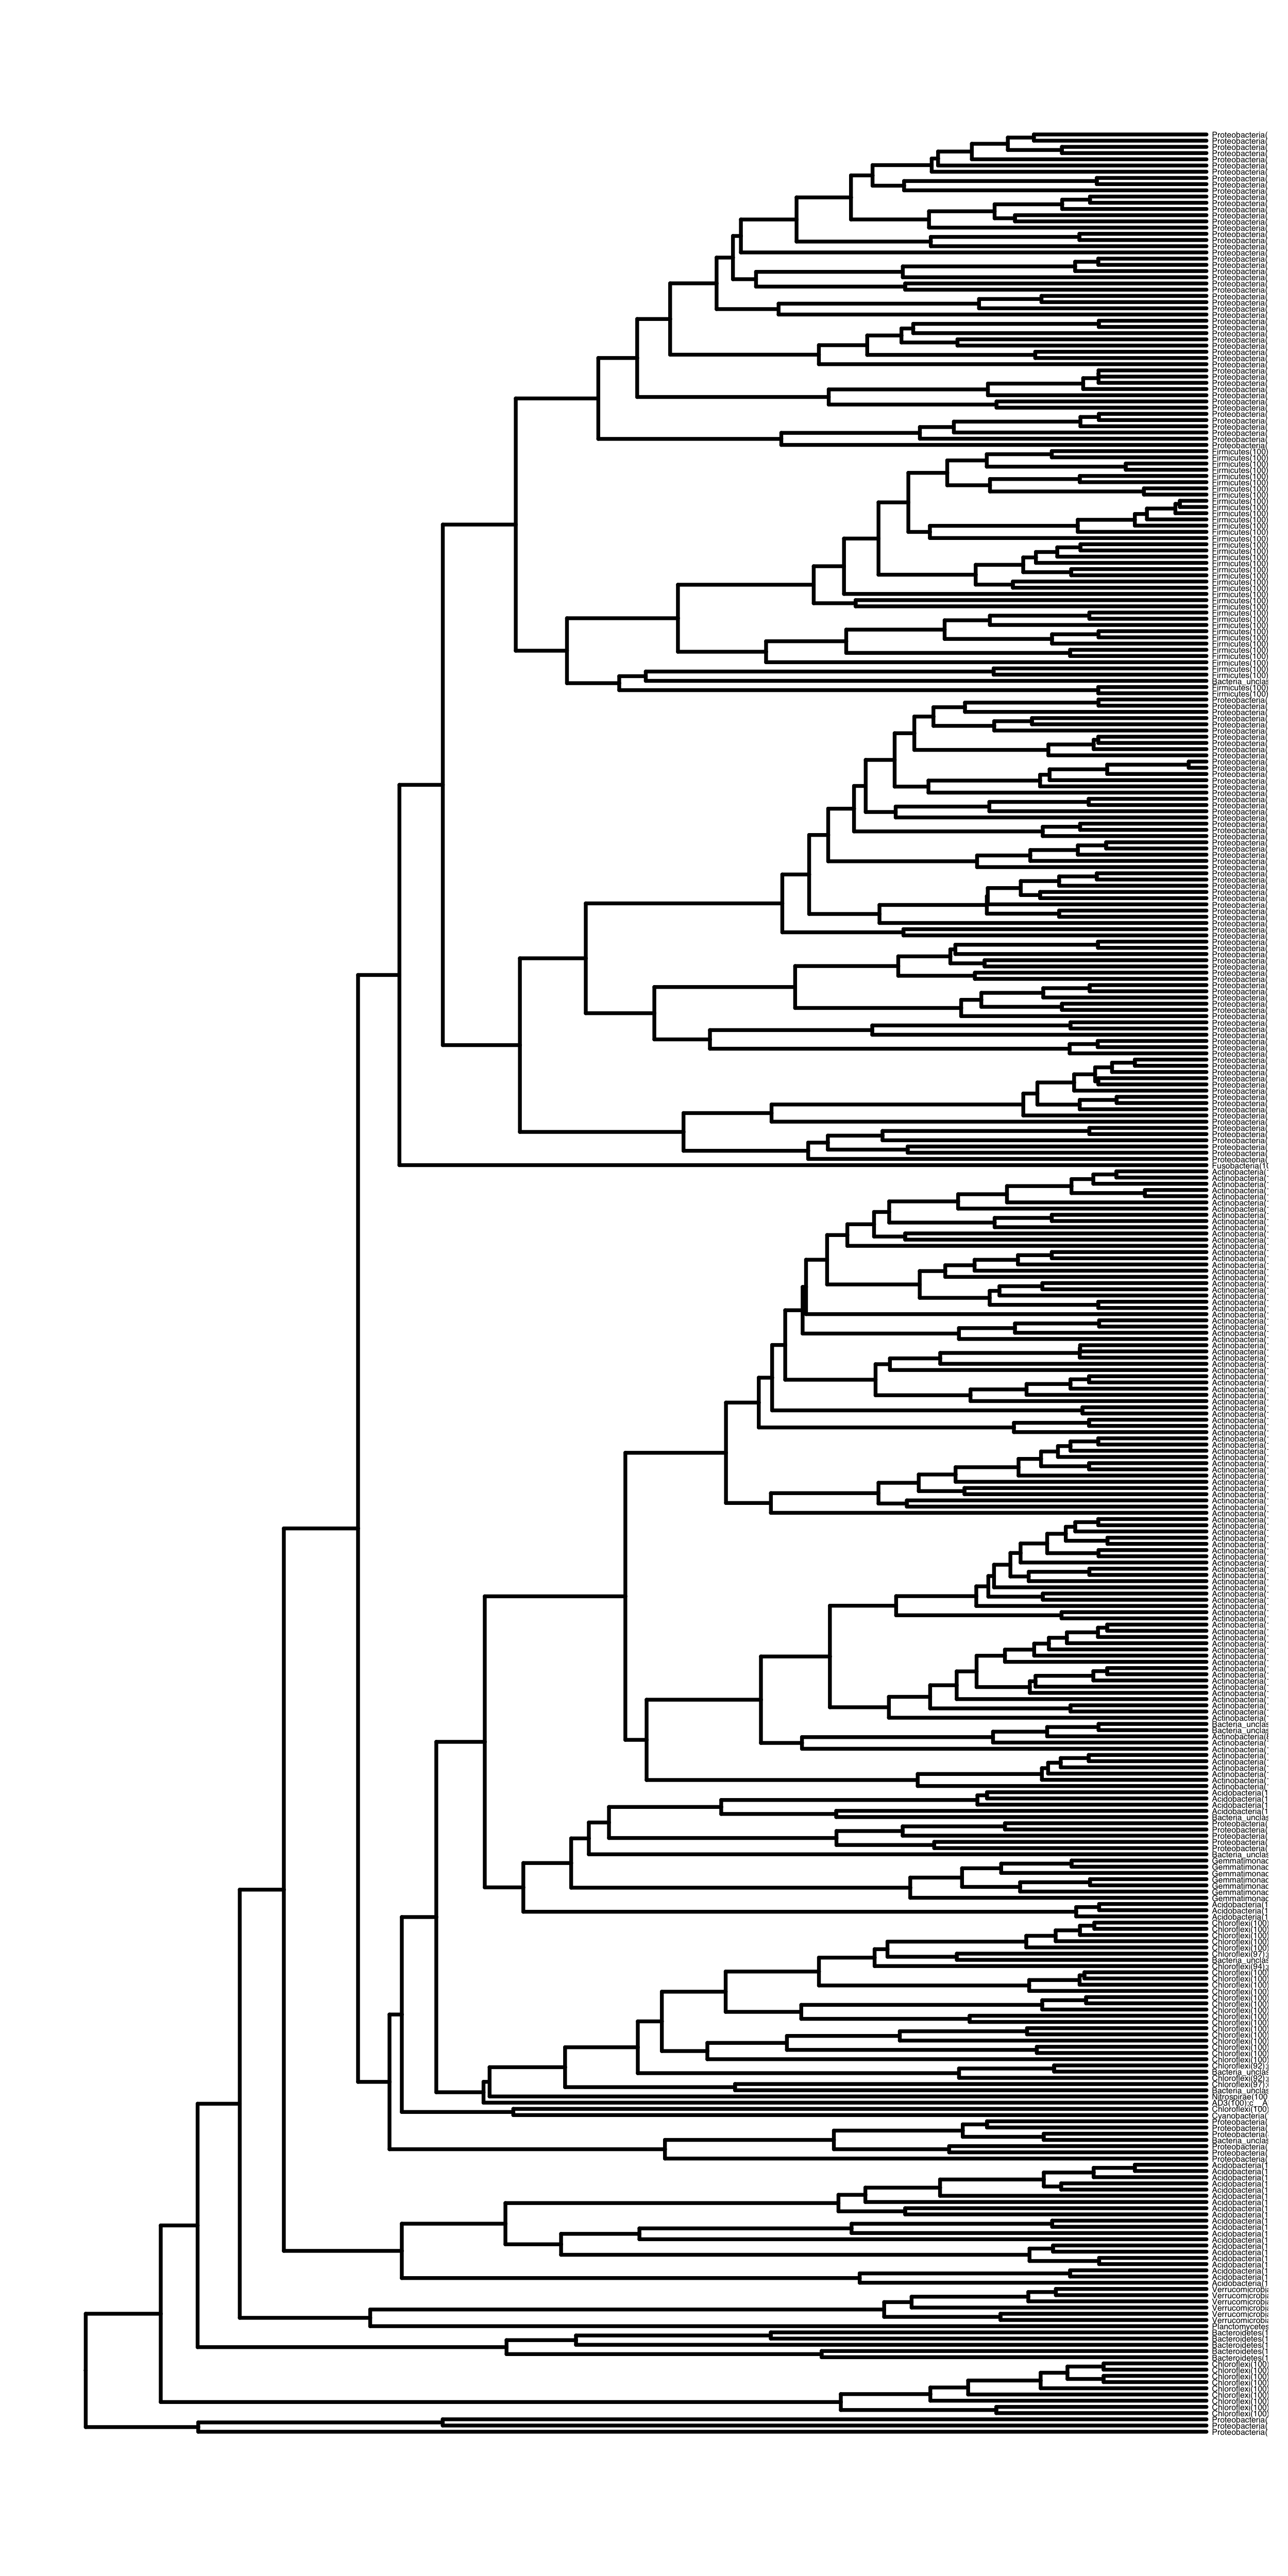

In [25]:
options(repr.plot.width=5, repr.plot.height=10,repr.plot.res=500)
ggtree(treeUPGMA) + geom_tiplab(size=0.8)

The `layout` parameter in ggtree defines the shape of the tree. Other options are: "slanted", "fan", "circular", "equal_angle", "daylight". 

**Exercise**: plot the same rooted tree with the parameter "fan".

In [26]:
options(repr.plot.width=5, repr.plot.height=4,repr.plot.res=500)
## type here your answer

**Exercise**: plot the NJ tree in the "equal_angle" layout.

In [ ]:
## type here your answer

## Character based methods


Instead of a distance matrix, the difference among the nucleotides is computed and fitted to a substitution model. A tree that explains this model is fitted to the data. 

Advantages: 
- Uses all the information available in sequences at each homologous site
- Output measure of how good is the tree

Disadvantage:
- Computationally demanding

### Maximum parsimony

>The most believable or parsimonious phylogenetic tree will be the tree that invokes the smallest number of evolutionary changes during the divergence of the sequences it represents.


Compute the parsimony score for the two trees computed so far. The output integer for the `parsimony` function, given a tree and its corresponding alignment, is the parsimony score. The parsimony score is defined as the number of changes which are at least necessary to describe the data for a given tree.

In [27]:
parsimony(treeUPGMA, alignment)
parsimony(treeNJ, alignment)

[1] 7310

[1] 7166

**Exercise**: which tree is more believable?

*type here your answer*

Use the function `optim.parsimony` performs tree rearrangements to find trees with a lower parsimony score. The tree rearrangement implemented are
nearest-neighbor interchanges (NNI) and subtree pruning and regrafting (SPR).

In [28]:
treePars  <- optim.parsimony(treeUPGMA, alignment)

Final p-score 6949 after  99 nni operations 


![](nni.png)

Perform the optimization but using the parsimony ratchet algorithm.

In [29]:
treeRatchet  <- pratchet(alignment, trace = 0)
parsimony(c(treePars, treeRatchet), alignment)

[1] 6949 6909

**Exercise**: Which optimization performs better?

*type here your answer*

### Maximum likelihood

>The basic concept of likelihood is relatively simple to comprehend: given some data D (in our case, nucleotide or amino acid sequences), under a model of evolution, M (which is explicitly defined and describes the mutation process from one base to another), the likelihood of a set of parameters, θ (tree topology, tree branch lengths, substitution model parameters), corresponds to the probability of obtaining D under the model M with parameters θ. The maximum likelihood estimates of the parameter values included in θ correspond to the set of values that maximize this probability.

Calculate the maximum likelihood tree. The `pml` model contains the tree and different parameters of the model. 

In [30]:
fit = pml(treeNJ, data = alignment)
fit


 loglikelihood: -39492.66 

unconstrained loglikelihood: -2233.097 

Rate matrix:
  a c g t
a 0 1 1 1
c 1 0 1 1
g 1 1 0 1
t 1 1 1 0

Base frequencies:  
0.25 0.25 0.25 0.25 

Branch length optimization using Jukes-Cantor model (all base changes equally likely) with the function `optim.pml` and default values.

In [31]:
fitJC  <- optim.pml(fit, TRUE)
logLik(fitJC)

optimize edge weights:  -39492.66 --> -38681.85 
optimize edge weights:  -38681.85 --> -38681.83 
optimize topology:  -38681.83 --> -38405.32 
optimize topology:  -38405.32 --> -38210.62 
optimize topology:  -38210.62 --> -38151.12 
87 
optimize edge weights:  -38151.12 --> -38150.95 
optimize topology:  -38150.95 --> -38113.53 
optimize topology:  -38113.53 --> -38083.31 
optimize topology:  -38083.31 --> -38076.9 
30 
optimize edge weights:  -38076.9 --> -38076.9 
optimize topology:  -38076.9 --> -38067.78 
optimize topology:  -38067.78 --> -38051.36 
optimize topology:  -38051.36 --> -38038.79 
9 
optimize edge weights:  -38038.79 --> -38038.79 
optimize topology:  -38038.79 --> -38035.06 
optimize topology:  -38035.06 --> -38032.64 
optimize topology:  -38032.64 --> -38027.72 
4 
optimize edge weights:  -38027.72 --> -38027.72 
optimize topology:  -38027.72 --> -38027.72 
0 
optimize edge weights:  -38027.72 --> -38027.72 


'log Lik.' -38027.72 (df=739)

Change fitting to GTR model. 

In [32]:
fitGTR <- update(fit, k = 4, inv = 0.2)

Optimize all parameters to this model.

In [37]:
fitGTR <- optim.pml(fitGTR, model="GTR", optInv=TRUE, optGamma=TRUE,
                    rearrangement = "NNI", control = pml.control(trace = 0))

In [38]:
fitGTR


 loglikelihood: -30848.08 

unconstrained loglikelihood: -2233.097 
Proportion of invariant sites: 0.2649096 
Discrete gamma model
Number of rate categories: 4 
Shape parameter: 0.5215117 

Rate matrix:
         a        c        g        t
a 0.000000 1.444900 3.660148 1.775254
c 1.444900 0.000000 1.113991 4.563277
g 3.660148 1.113991 0.000000 1.000000
t 1.775254 4.563277 1.000000 0.000000

Base frequencies:  
0.1921395 0.2438611 0.3189534 0.245046 

**Exercise**: inspect the object fitGTR with the `attributes` function, where's the tree?

In [ ]:
## type here your answer

In [39]:
options(repr.plot.width=5, repr.plot.height=9,repr.plot.res=500)

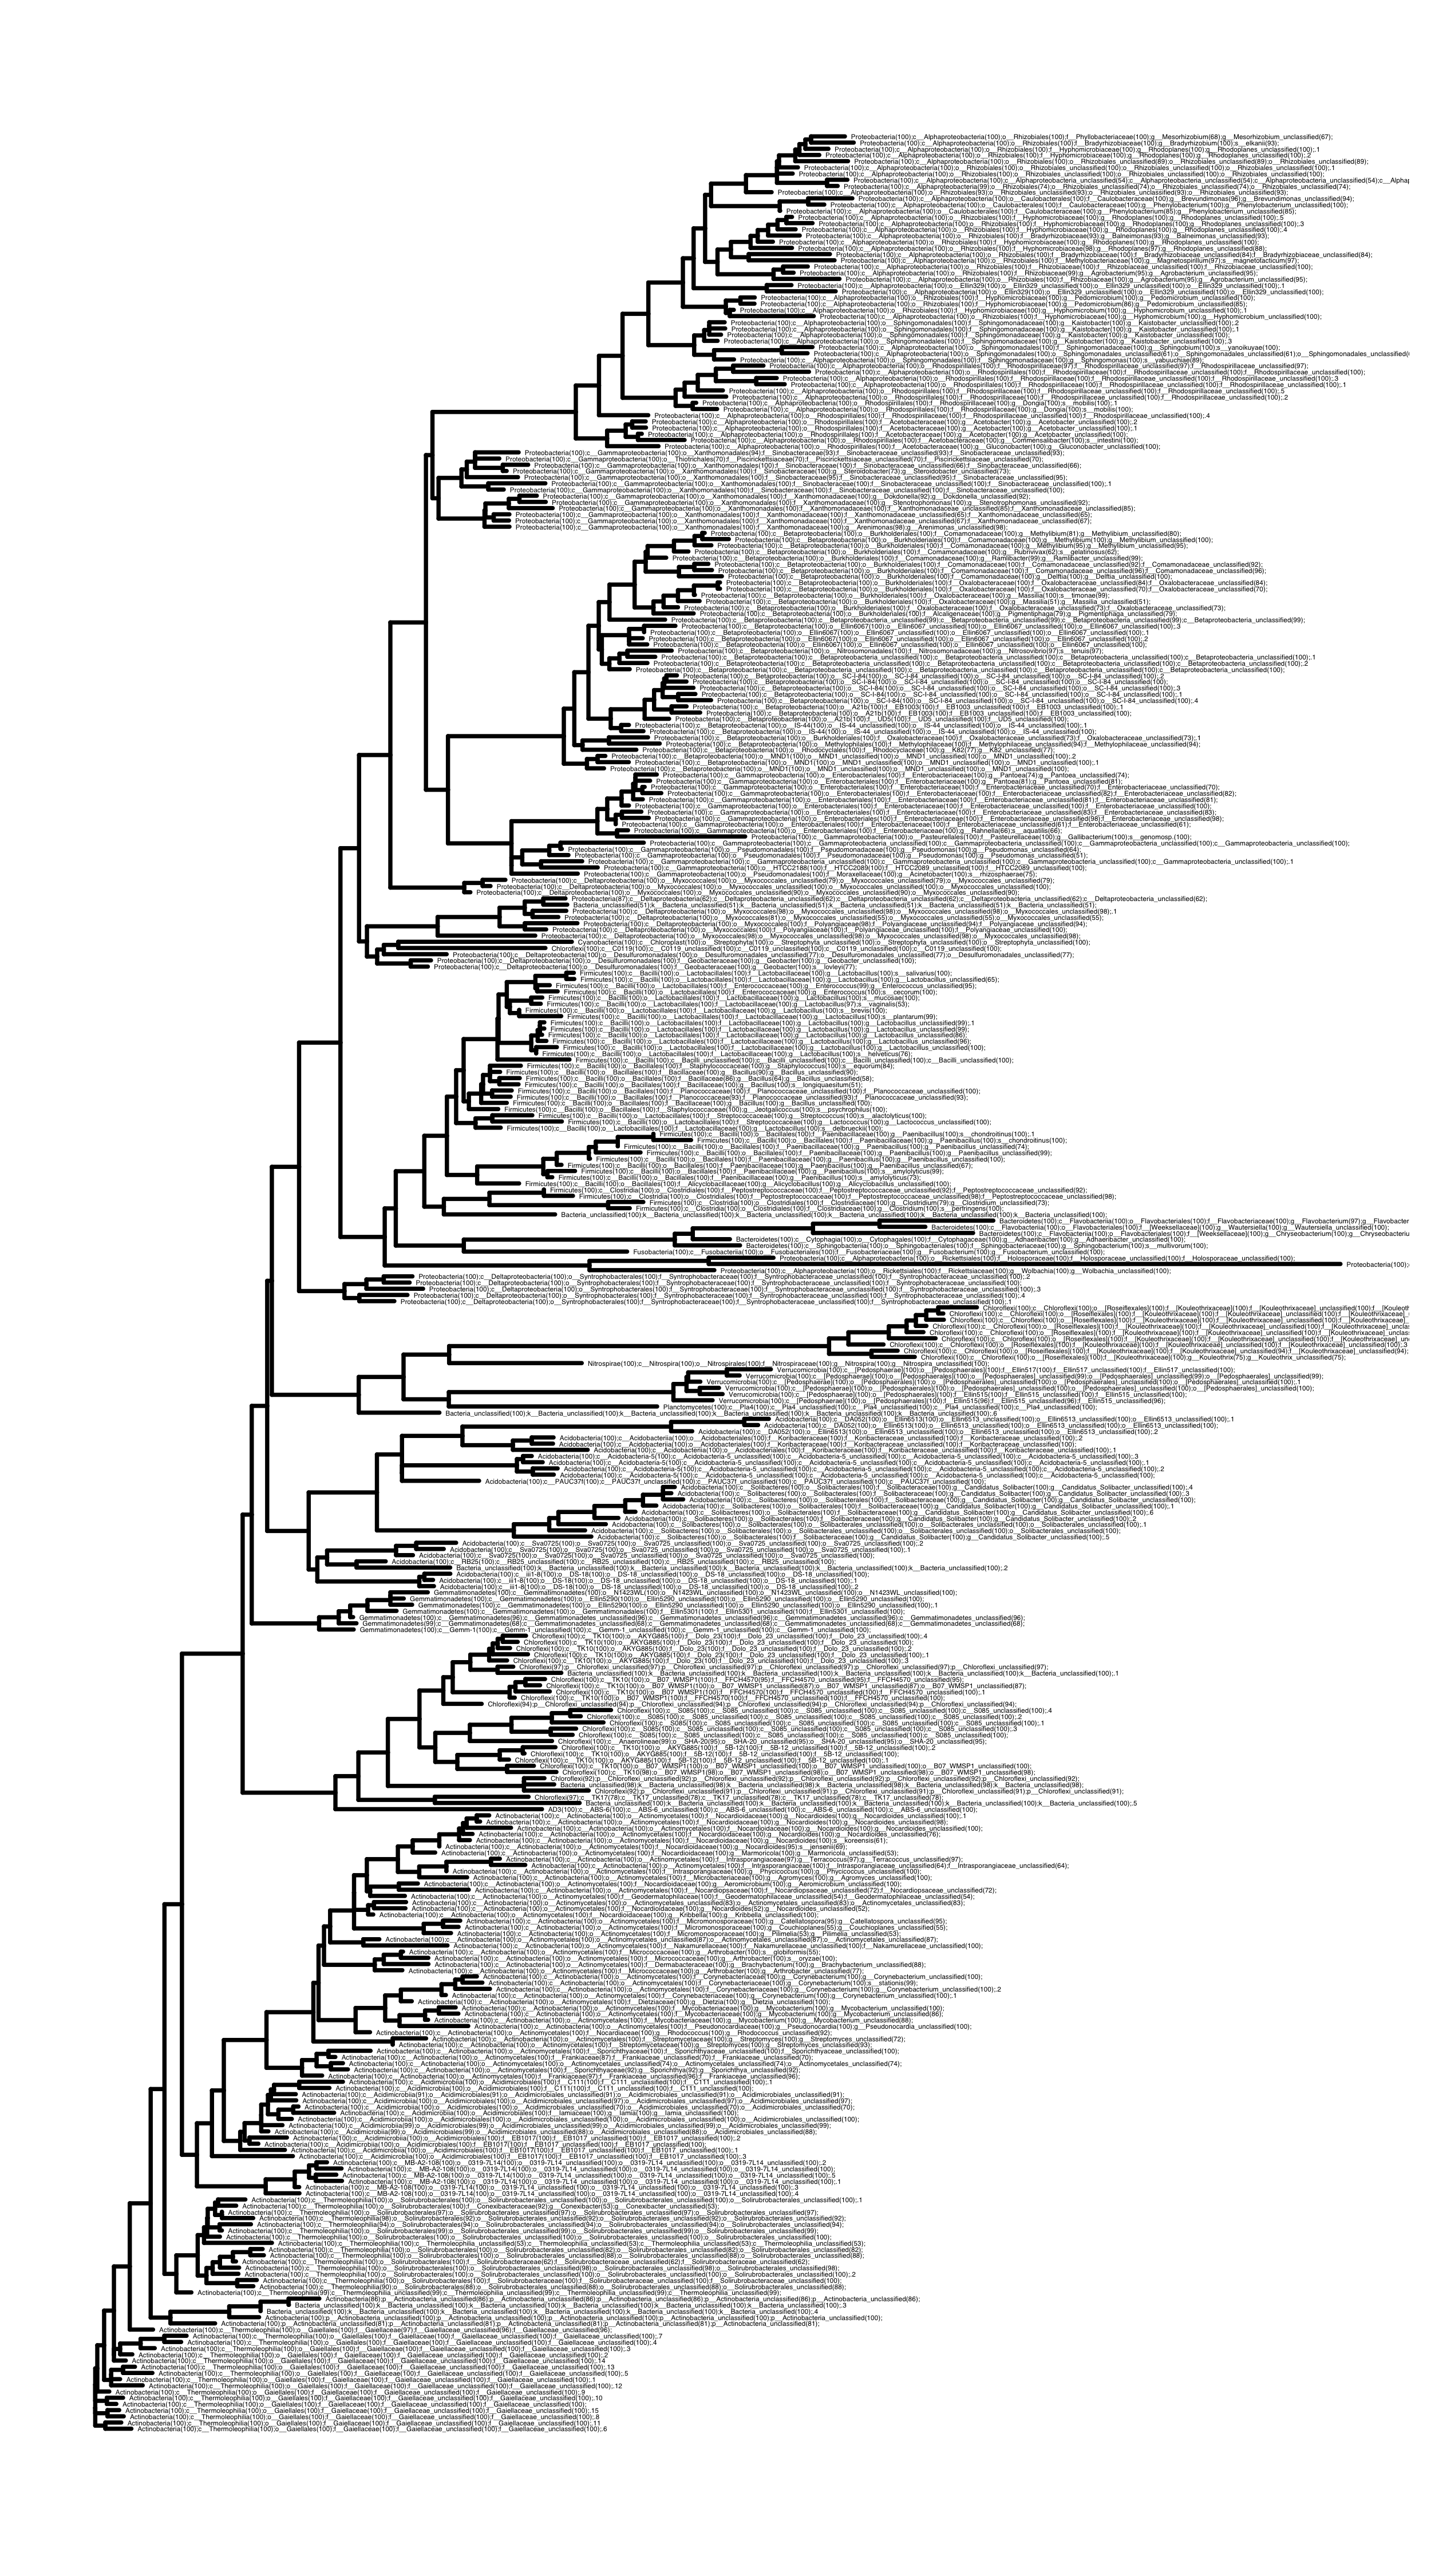

In [40]:
ggtree(fitGTR$tree) + geom_tiplab(size=0.6)

Trim the name of the leave to the first word (the phylum). This is done using a regex expression that removes everything after the first `(` (substitutes it by nothing).

In [41]:
fitGTR$tree$tip.label <- gsub('\\(.*$',"",fitGTR$tree$tip.label)

Plot the grouped OTUs, using the `groupOTU` function on some of the most abundant phyla before plotting the tree.

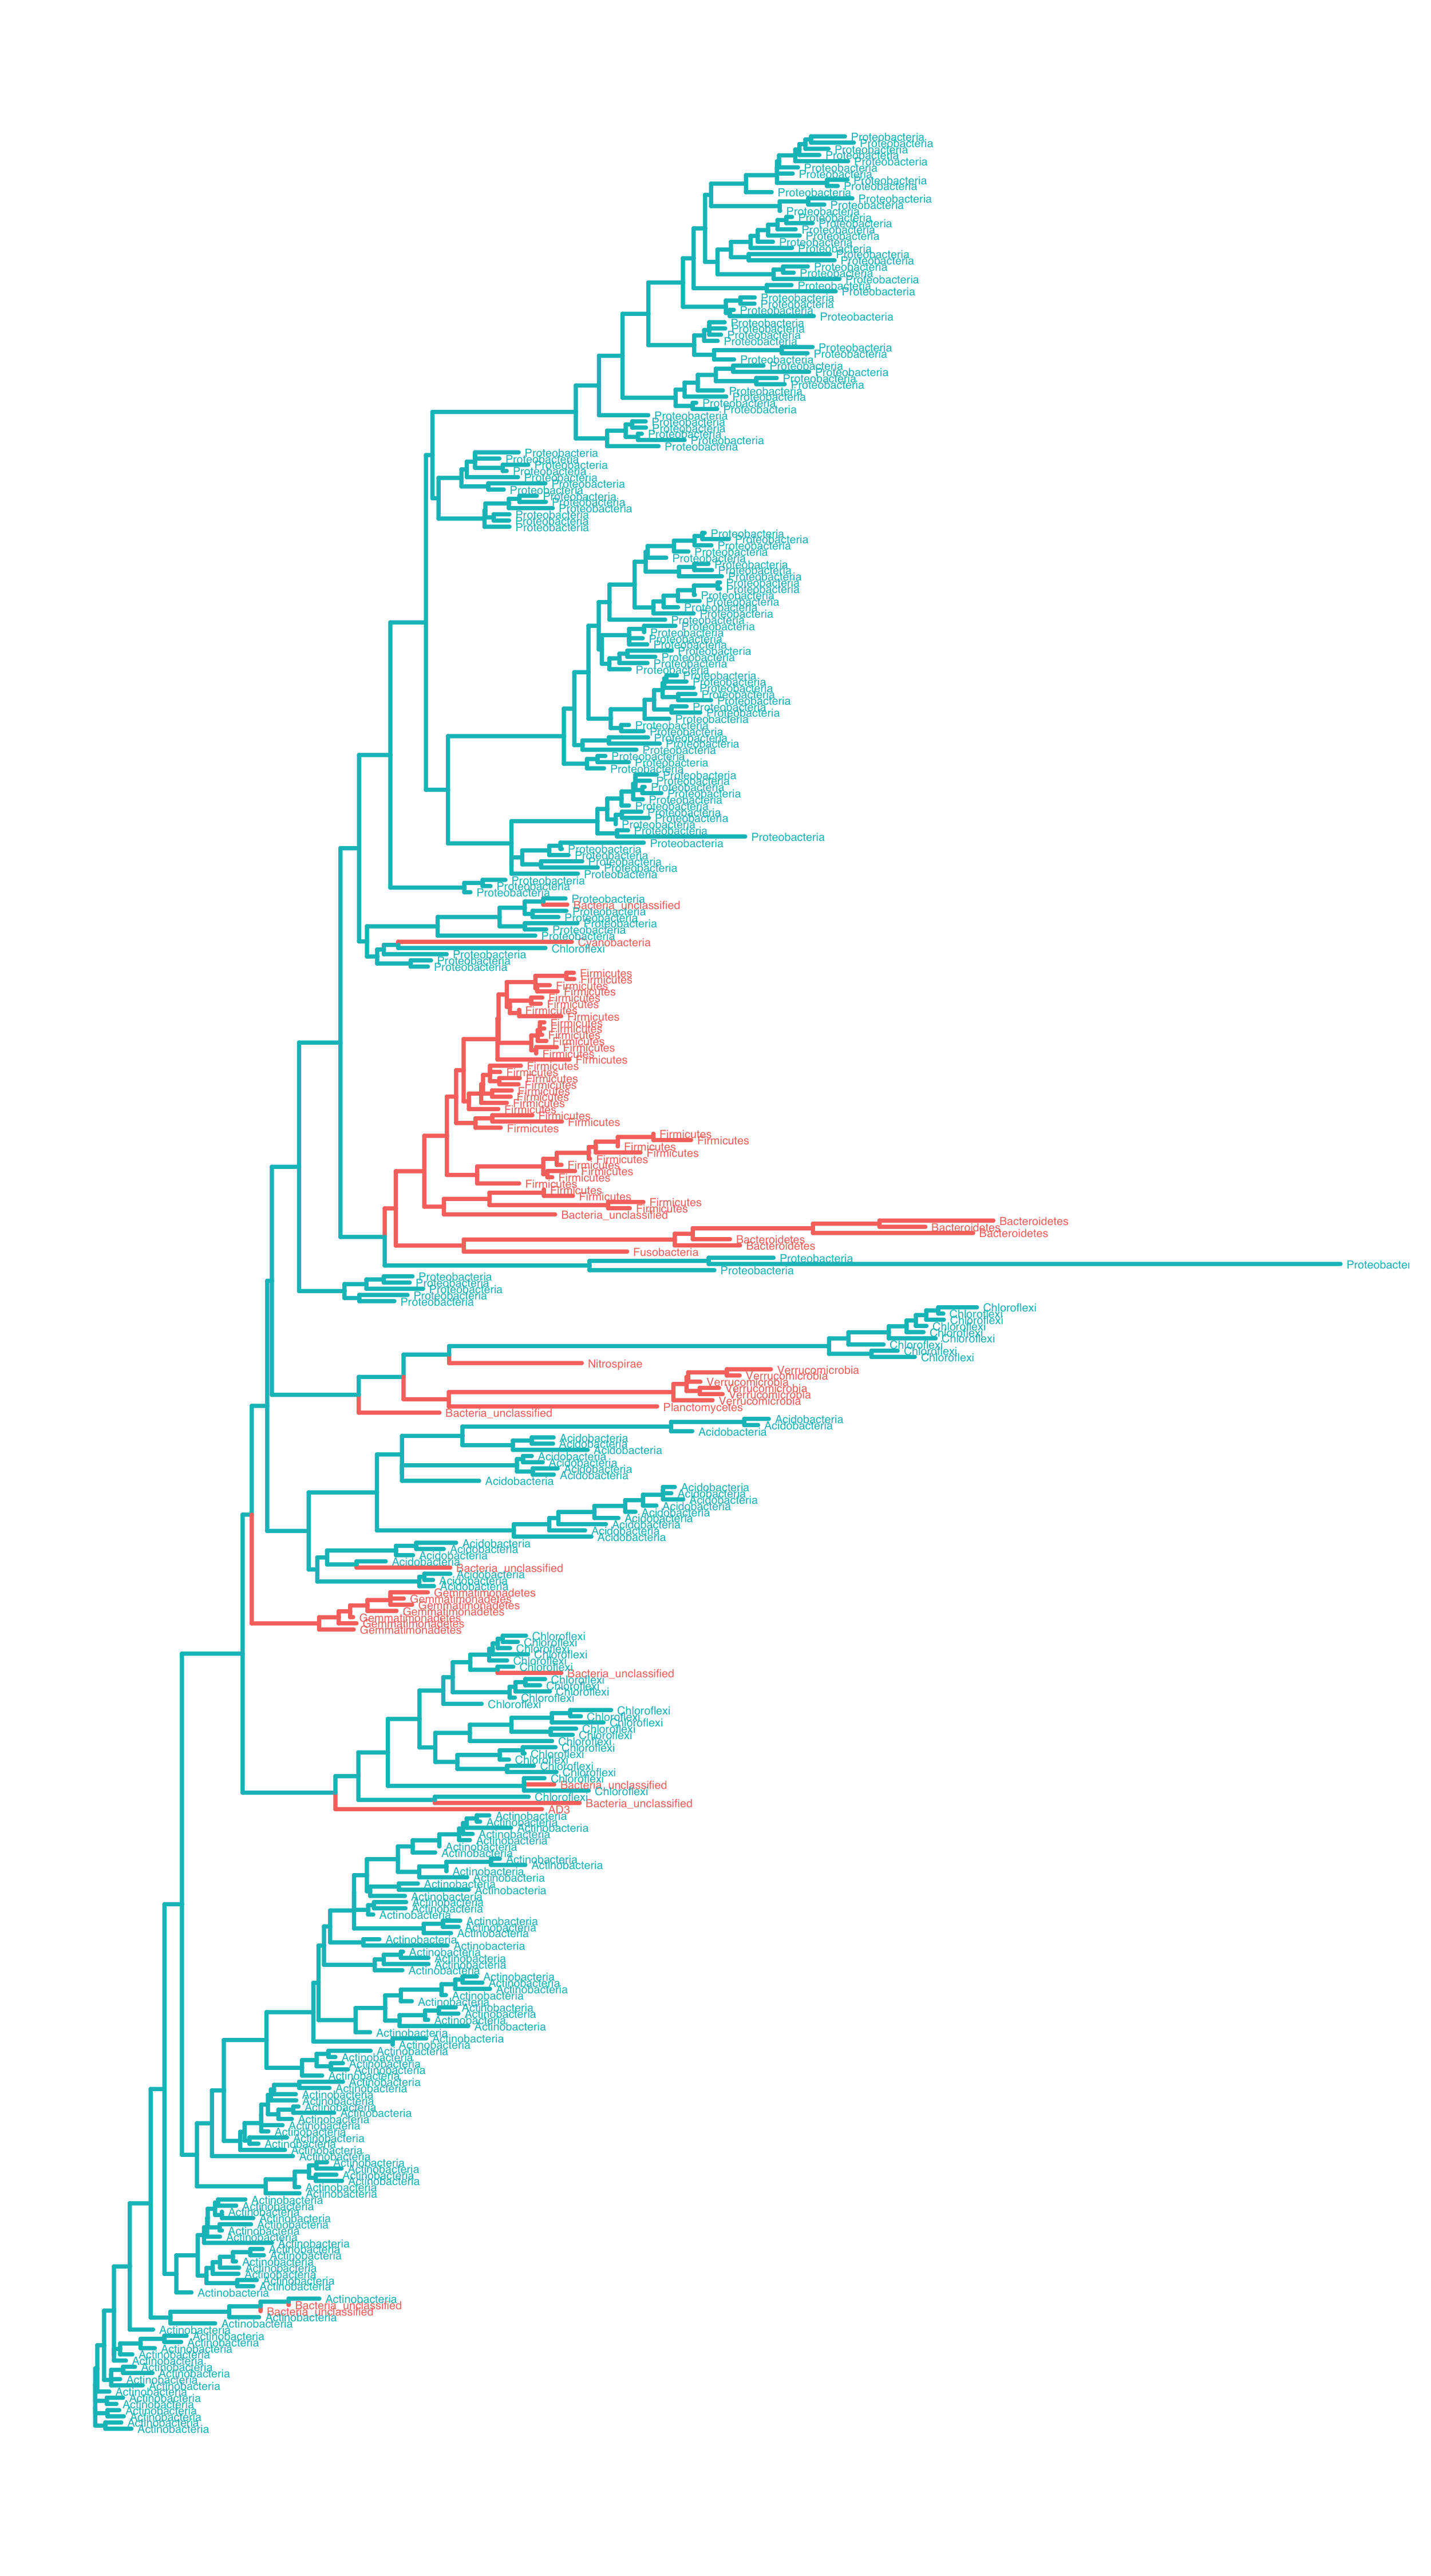

In [42]:
grouped_tree <- groupOTU(fitGTR$tree, c("Proteobacteria", "Actinobacteria", "Chloroflexi", "Acidobacteria"))

ggtree(grouped_tree, aes(color=group)) + geom_tiplab(size =1)

**Exercise**: what would you expect the unclassified OTU's to be?

*type here your answer*

Show label for all of the internal nodes.

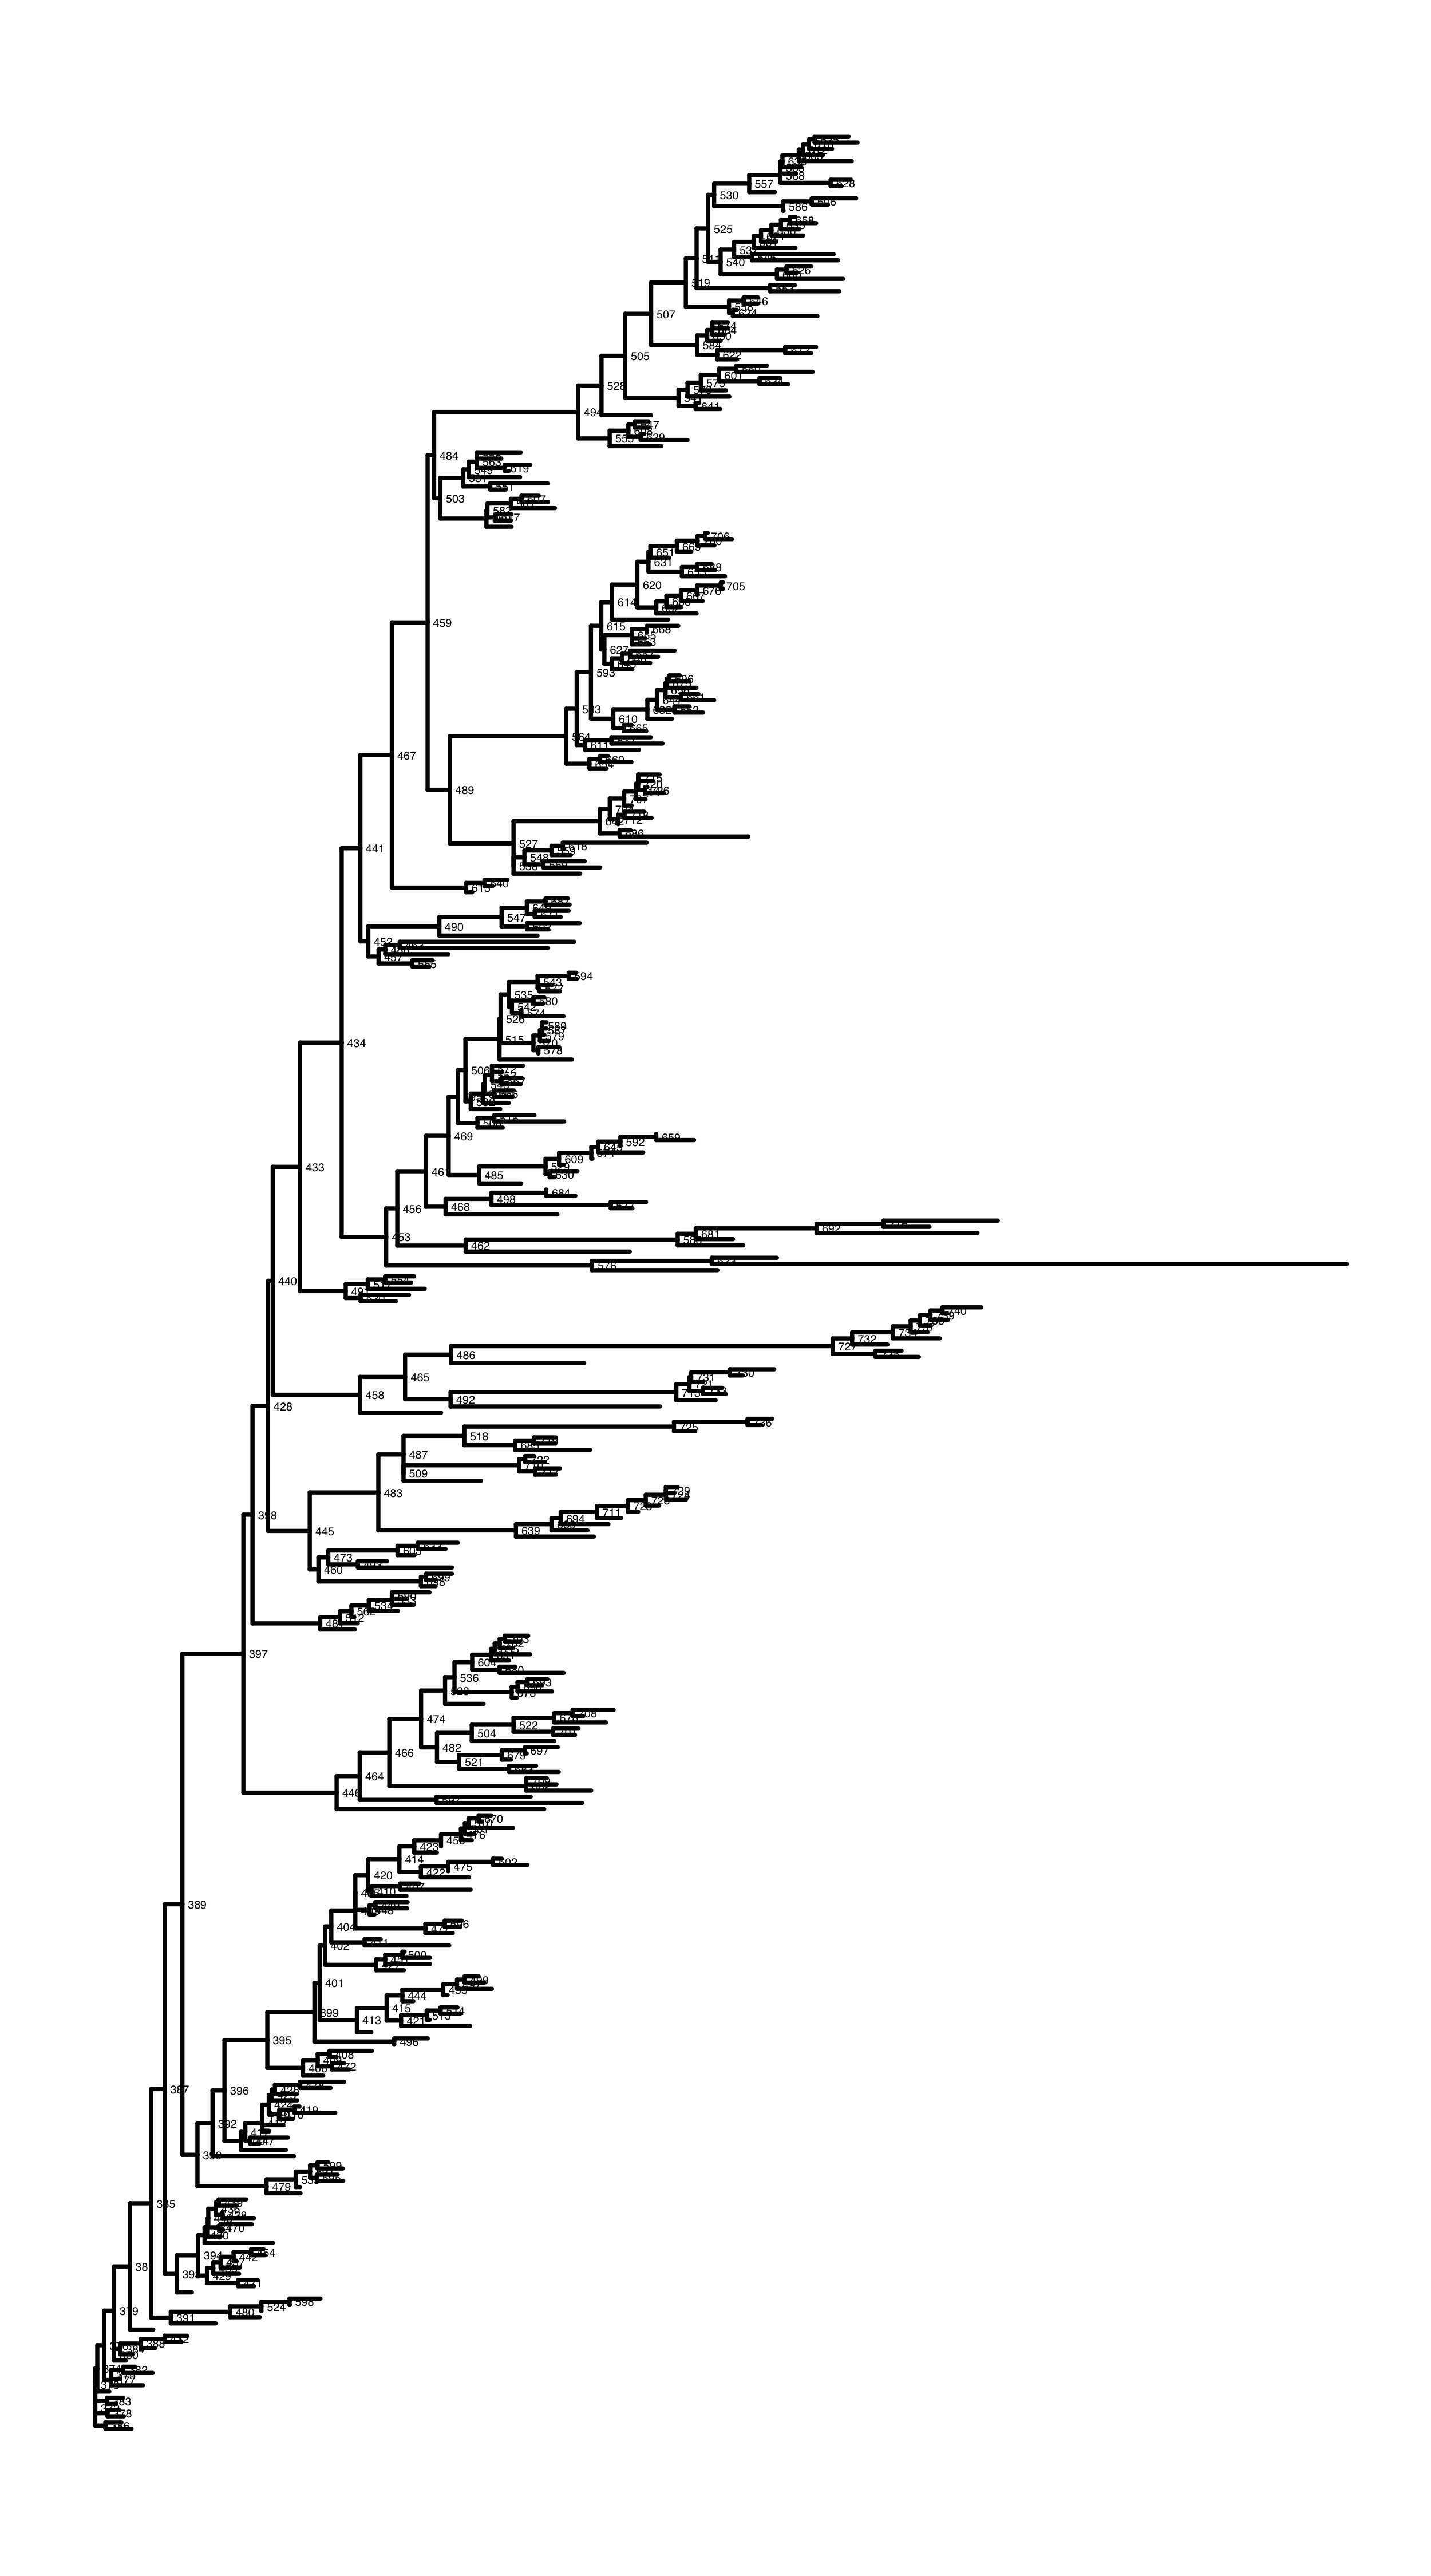

In [43]:
ggtree(fitGTR$tree) + geom_text2(aes(subset=!isTip, label=node), hjust=-.3, size = 1)

Highlight *betaproteobacteria* clade in green.

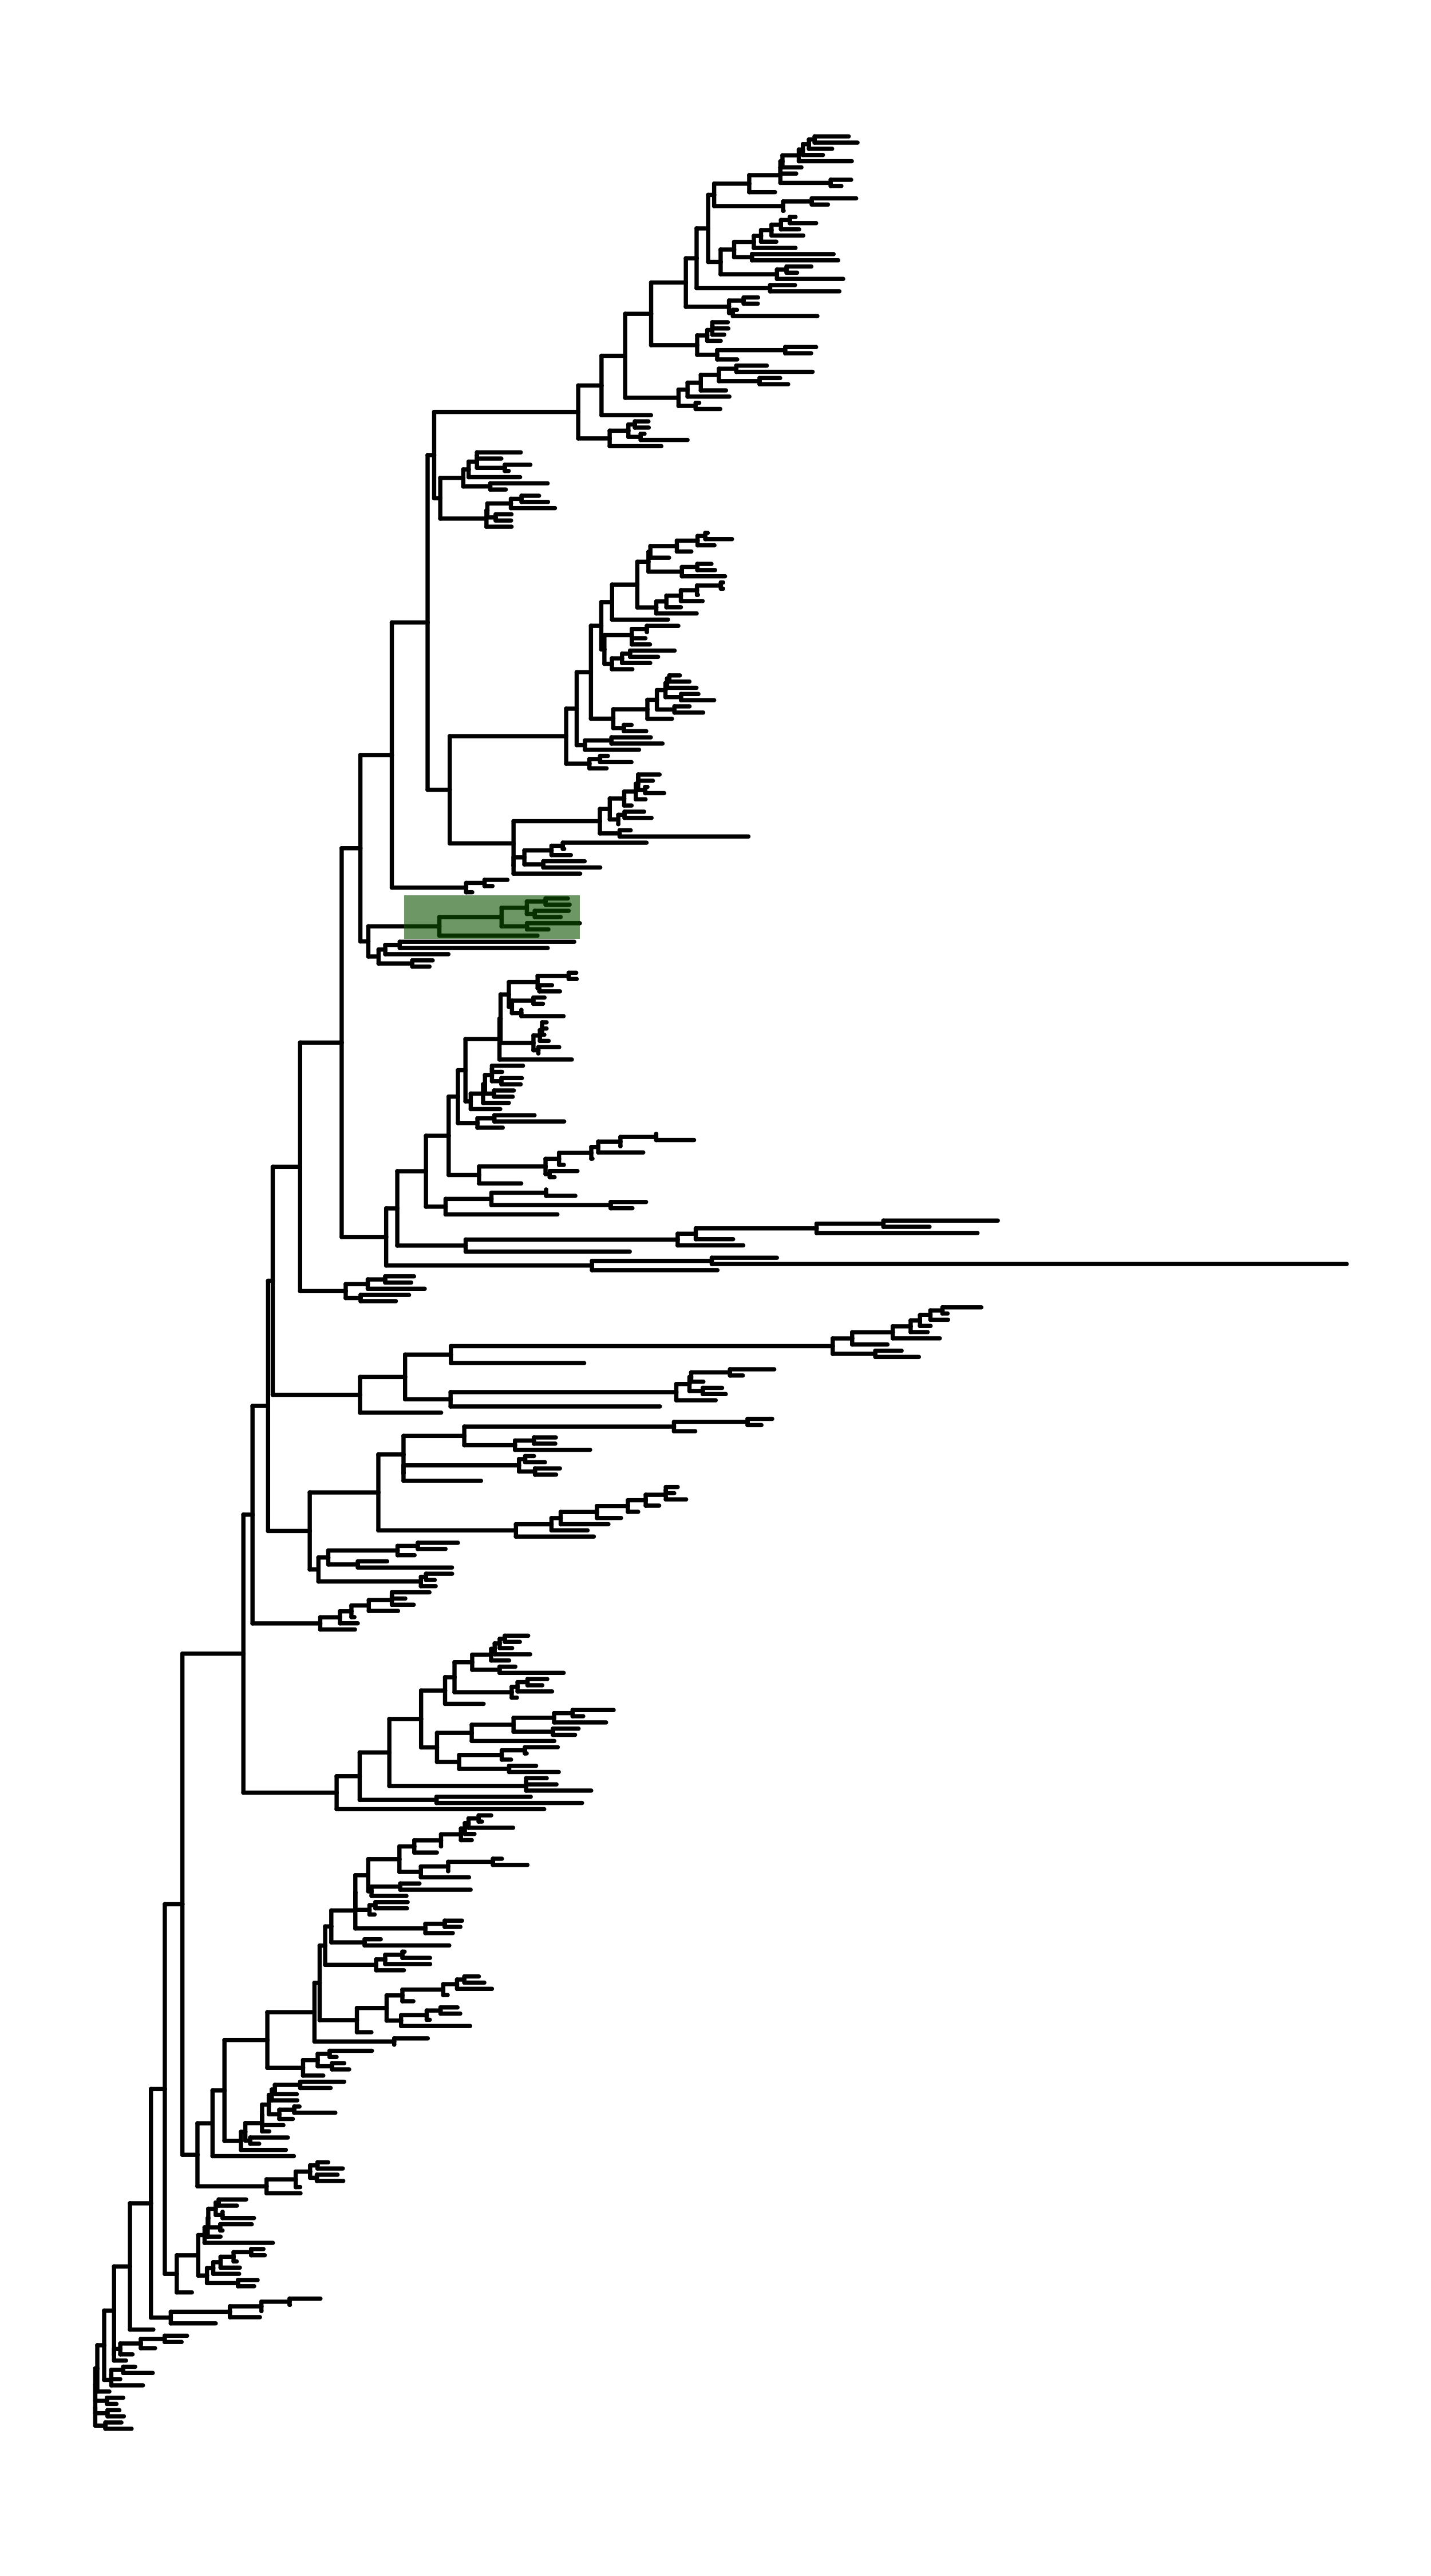

In [44]:
ggtree(fitGTR$tree) + geom_hilight(node=490, fill="darkgreen", alpha=.6) ## change the node number to fit the actual clade

**Exercise**: highlight also the *alphaproteobacteria* clade in blue.

In [45]:
## type here your answer

## Model selection

![](models.png) 

Compare nested models for JC and GTR using likelihood ratio statistic.

In [48]:
anova(fitJC, fitGTR)

Log lik.  Df  Df change Diff log lik. Pr(>|Chi|)
1 -38027.72 739 NA              NA      NA        
2 -30848.08 749 10        14359.29       0

Which nucleotide subtitution model is more likely?

In [49]:
mt = modelTest(alignment)

[1] "JC+I"
[1] "JC+G"
[1] "JC+G+I"
[1] "F81+I"
[1] "F81+G"
[1] "F81+G+I"
[1] "K80+I"
[1] "K80+G"
[1] "K80+G+I"
[1] "HKY+I"
[1] "HKY+G"
[1] "HKY+G+I"
[1] "SYM+I"
[1] "SYM+G"
[1] "SYM+G+I"
[1] "GTR+I"
[1] "GTR+G"
[1] "GTR+G+I"


**Exercise**: inspect the results for the model test, which nucleotide substitution model is more likely?

In [ ]:
## type here your answer

## OTU table

Read the OTU table file.

In [51]:
otu_table <- read_delim("BV5.trim.contigs.good.renamed.unique.pick.dgc.unique_list.0.03.abund.0.03.rep.count_table","\t")
otu_table <- column_to_rownames(otu_table, var = "Representative_Sequence")

Parsed with column specification:
cols(
  Representative_Sequence = col_character(),
  total = col_double(),
  B5.145 = col_double(),
  B5.146 = col_double(),
  B5.147 = col_double(),
  B5.148 = col_double(),
  B5.149 = col_double(),
  B5.150 = col_double(),
  B5.151 = col_double(),
  B5.152 = col_double(),
  B5.153 = col_double(),
  B5.154 = col_double(),
  B5.155 = col_double(),
  B5.156 = col_double()
)


Change to original sequence names back from the taxonomy.

In [52]:
bv5nt <- read.fas("BV5.trim.contigs.good.renamed.unique.pick.dgc.unique_list.0.03.abund.0.03.rep.fasta")
bv5nt <- bv5nt[startsWith(names(bv5t), "k__Bacteria(100)")]
aln <- alignment
names(aln) <- names(bv5nt)

Make a tree again using ML and the GTR substitution model.

In [53]:
treeNJ1  <- NJ(dist.ml(aln))

fit1 = pml(treeNJ1, data=aln)

fitGTR1 <- update(fit1, k=4, inv=0.2)

fitGTR1 <- optim.pml(fitGTR1, model="GTR", optInv=TRUE, optGamma=TRUE,
                    rearrangement = "NNI", control = pml.control(trace = 0))

Store tree figure with annotated clades as `p` variable.

In [67]:
p <- ggtree(fitGTR1$tree,branch.length = "none") + 
    geom_hilight(node=490, fill="darkgreen", alpha=.6) + 
    geom_hilight(node=488, fill="steelblue", alpha=.6)  ## change the node numbers to fit the actual clade

Plot the OTU table for the 12 samples as a heatmap of their abundance. Notice the log transformation on the OTU abundance.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


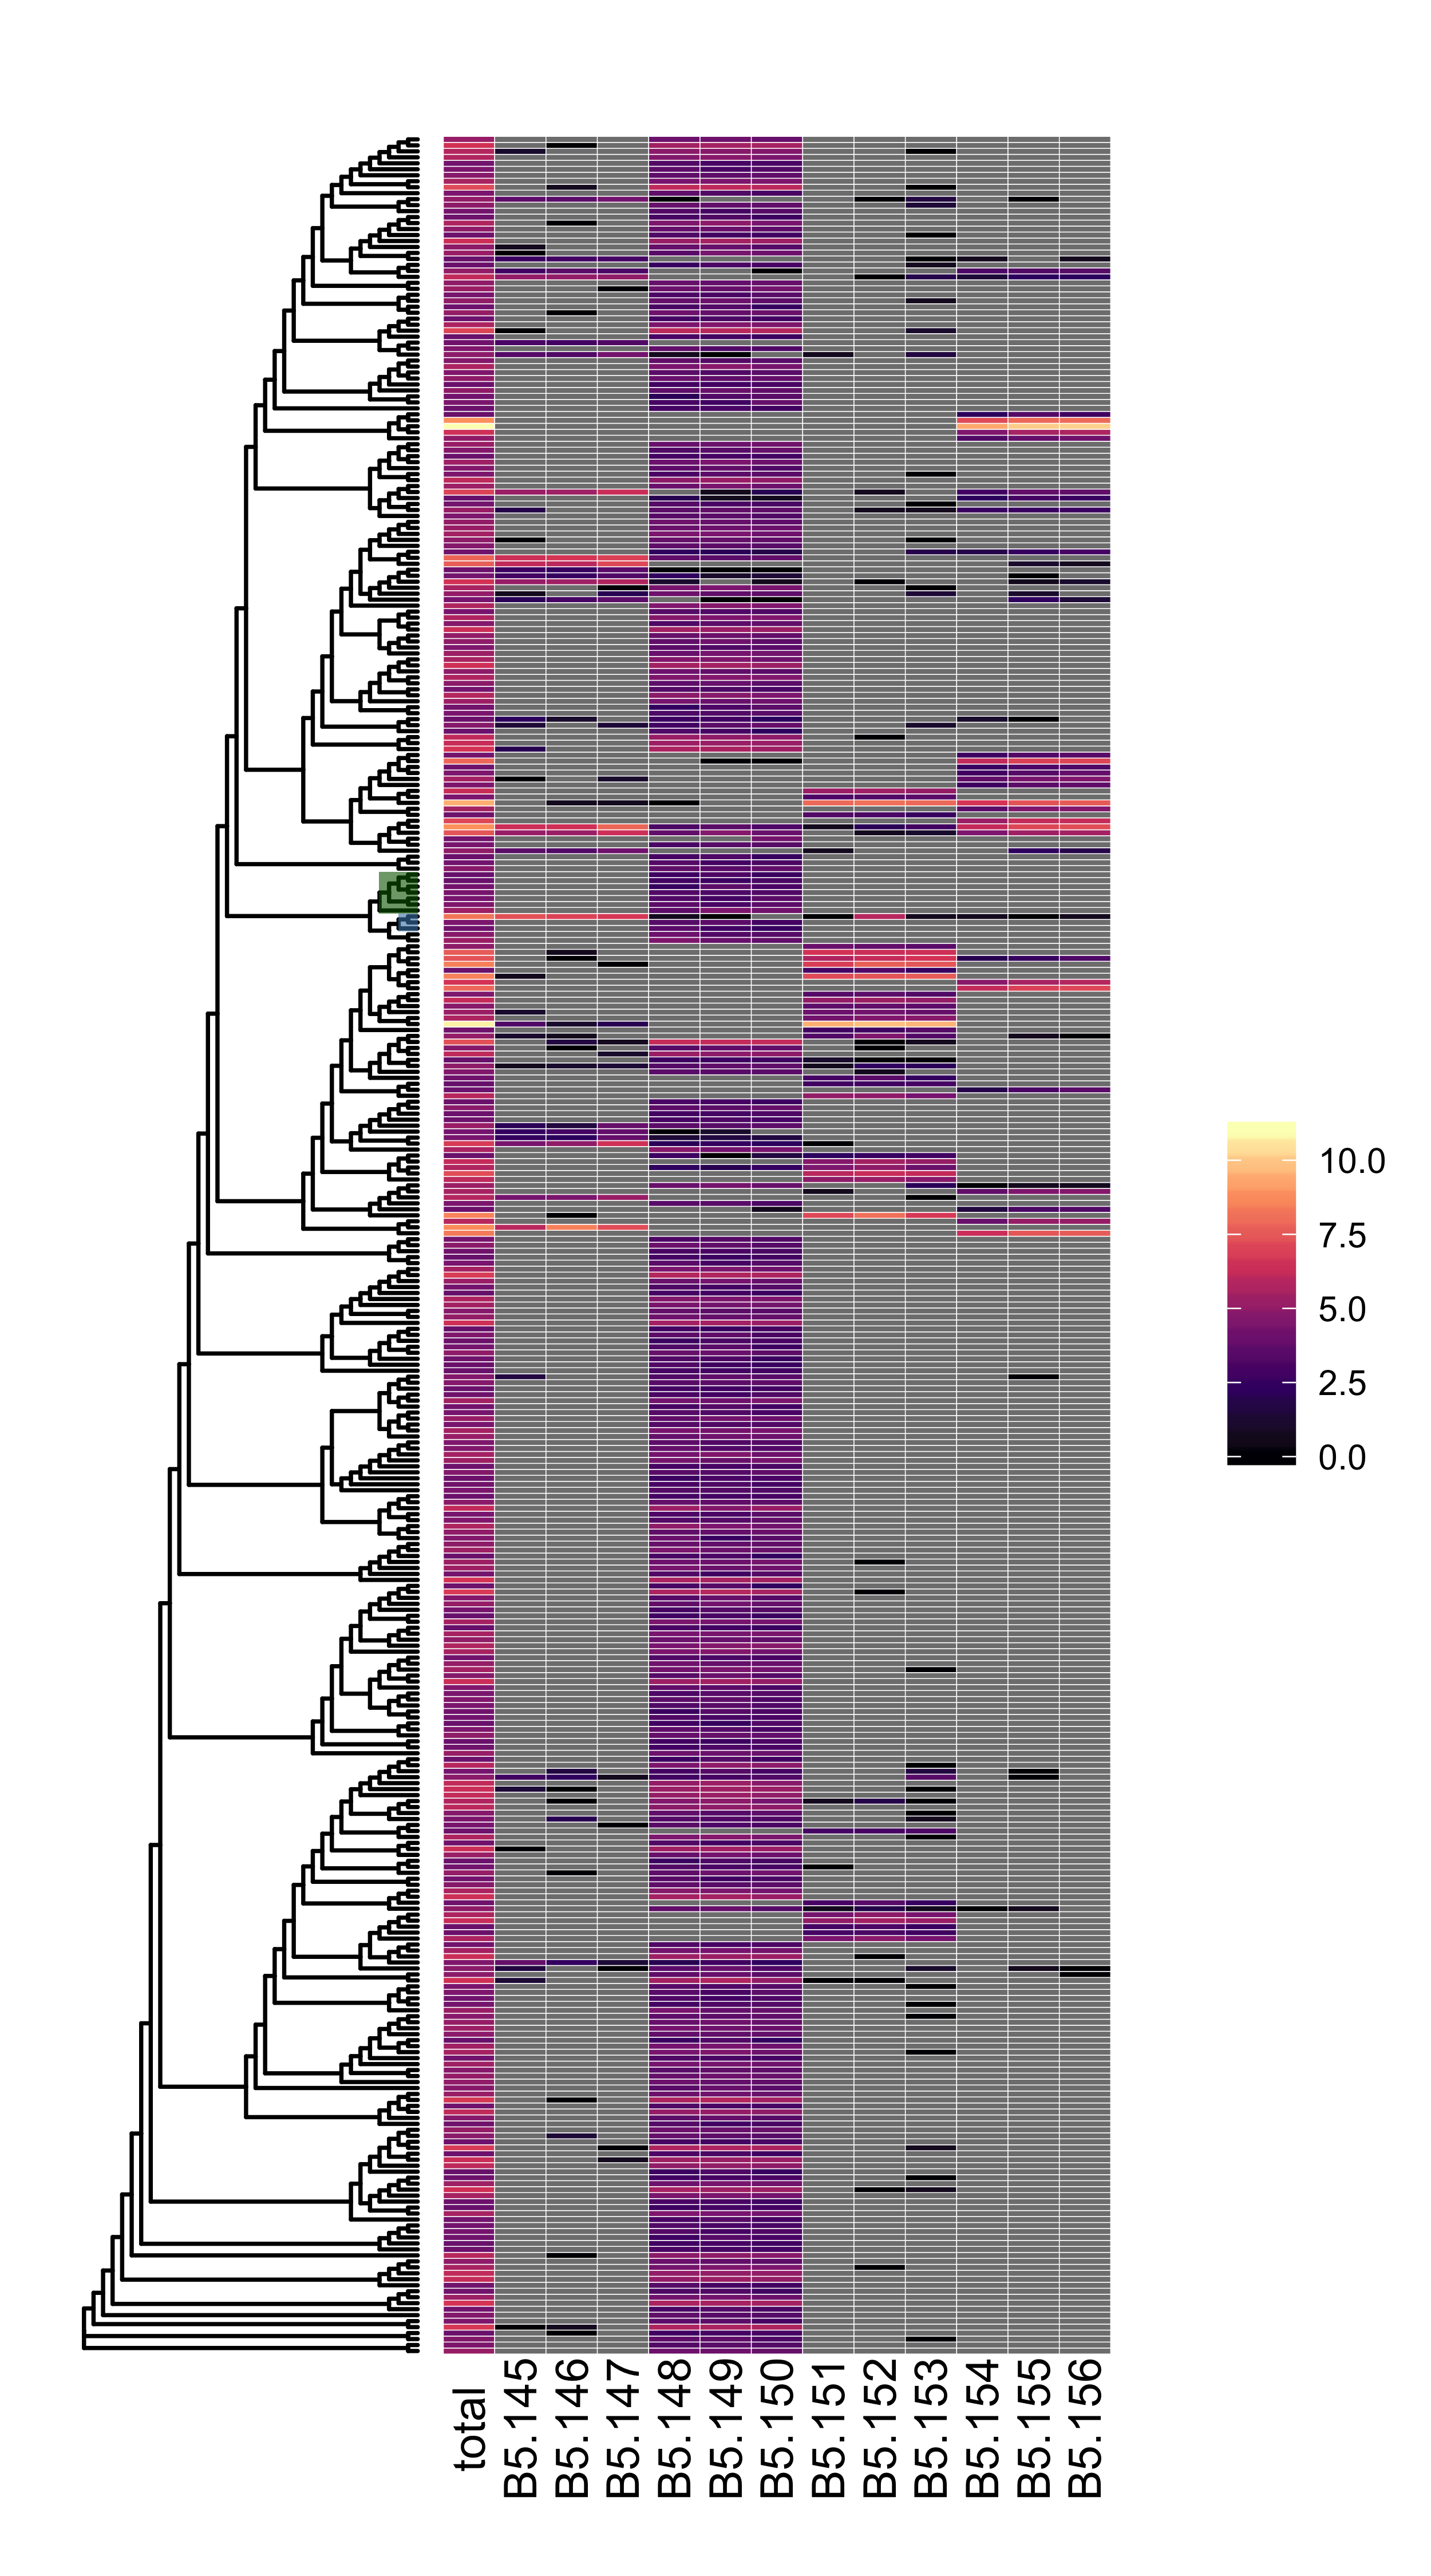

In [68]:
gheatmap(p,log(otu_table), width = 2, colnames_angle = 90, colnames_offset_y = -12) + 
scale_fill_viridis_c(option="A")

**Exercise**: are the taxa consistent along different types of sample? what are the more striking differences? 

How are *Pseudomonas*, *Corynebacterium* and *Acetobacter* distributed across the different samples?


*type here your answer*